In [1]:
import os
os.chdir('../')
print(os.listdir())

['.git', '.gitignore', '.idea', 'architecture-design', 'docker', 'drive-download-20211215T213754Z-001.zip', 'drive-download-20211221T190522Z-001.zip', 'evaluated-data', 'models', 'notebooks', 'README.md', 'scripts', 'simulated-data-raw', 'spark-warehouse', 'transformed-data', 'venv']


In [2]:

import findspark


findspark.init()
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql.functions import window, col, current_timestamp
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import sum,avg,max,min,mean,count, round


In [3]:
# from bokeh.io import output_notebook
# from bokeh.plotting import figure, show
# from bokeh.models import ColumnDataSource

import pandas as pd

# output_notebook()

In [4]:
# Spark session & context
spark = (SparkSession
         .builder
         .master('local')
         .appName('transactions-evaluator')
         .config("spark.sql.streaming.schemaInference", True) #Stream dataframe infers schema
         .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.2")
         .getOrCreate())


In [5]:
sc = spark.sparkContext

# Read parquet stream
df_stream = (
        spark
        .readStream
        .format("parquet")
        .load("evaluated-data/dataset")
)
df_agg = (
    df_stream\
#     .filter(col("TX_FRAUD")!=col("prediction").cast("int"))
    .groupBy(window(col("TX_DATETIME"), "30 minutes", "30 minutes"))
    .agg(
        round(count("CUSTOMER_ID")/50,2).alias("nx_transactions"),
        sum("TX_FRAUD").alias("real_frauds"),
        sum("prediction").alias("predicted_frauds")
    ))
queryStream = (df_agg
               .writeStream
               .format("memory")
               .queryName("df_stream")
               .outputMode("update")
               .start())

**********************
General Info
**********************
Run:5
Stream timestamp:2021-12-24T00:23:03.626Z


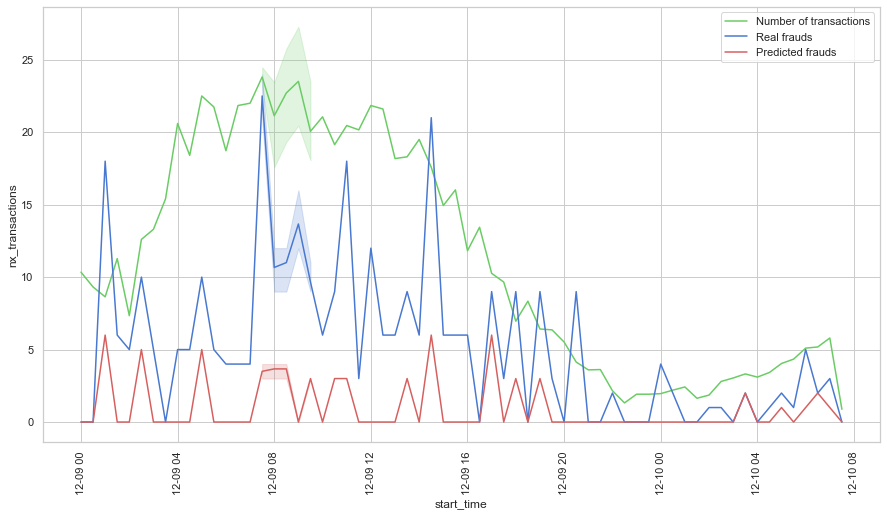

process interrupted.


In [8]:
from time import sleep
from IPython.display import clear_output
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='DejaVu Sans')
sns.set(style="whitegrid")


try:
    i=1
    while True:
        # Clear output
        clear_output(wait=True)
        print("**********************")
        print("General Info")
        print("**********************")
        print("Run:{}".format(i))
        if (len(queryStream.recentProgress) > 0):
            print("Stream timestamp:{}".format(queryStream.lastProgress["timestamp"]))
        
        df = spark.sql("select * from df_stream").toPandas()
        df['start_time']=df['window'].apply(lambda x: x[0])
        df = df.sort_values(by='start_time')
#         source = ColumnDataSource(df)
        # Plot the total crashes
        sns.set_color_codes("muted")

        # Initialize the matplotlib figure
        plt.figure(figsize=(15, 8))

#         print("**********************")
#         print("Graph - Top 10 users")
#         print("**********************")
        try:
#             # create a plot and renderer with ColumnDataSource data
#             p = figure(x_axis_type='datetime')
#             p.line(x='start_time', y='nx_transactions', source=source)
#             p.line(x='start_time', y='real_frauds', source=source)
#             p.line(x='start_time', y='predicted_frauds', source=source, line_color='red')
#             p.xaxis.major_label_orientation = "vertical"
#             show(p)
            # Barplot
            sns.lineplot(x="start_time", y="nx_transactions", data=df, color='g', label='Number of transactions')
            sns.lineplot(x="start_time", y="real_frauds", data=df, color='b', label='Real frauds')
            sns.lineplot(x="start_time", y='predicted_frauds', data=df, color='r', label='Predicted frauds')
            plt.xticks(rotation=90)
            # Show barplot
            plt.show()
        except ValueError:
            # If Dataframe is empty, pass
            pass


        sleep(30)
        i=i+1
except KeyboardInterrupt:
    print("process interrupted.")

In [9]:
df.sort_values(by='window')

,window,nx_transactions,real_frauds,predicted_frauds,start_time
58,"(2021-12-09 00:00:00, 2021-12-09 00:30:00)",10.34,0,0.0,2021-12-09 00:00:00
13,"(2021-12-09 00:30:00, 2021-12-09 01:00:00)",9.32,0,0.0,2021-12-09 00:30:00
57,"(2021-12-09 01:00:00, 2021-12-09 01:30:00)",8.64,18,6.0,2021-12-09 01:00:00
11,"(2021-12-09 01:30:00, 2021-12-09 02:00:00)",11.28,6,0.0,2021-12-09 01:30:00
23,"(2021-12-09 02:00:00, 2021-12-09 02:30:00)",7.34,5,0.0,2021-12-09 02:00:00
...,...,...,...,...,...
55,"(2021-12-10 05:30:00, 2021-12-10 06:00:00)",4.34,1,0.0,2021-12-10 05:30:00
21,"(2021-12-10 06:00:00, 2021-12-10 06:30:00)",5.10,5,1.0,2021-12-10 06:00:00
0,"(2021-12-10 06:30:00, 2021-12-10 07:00:00)",5.18,2,2.0,2021-12-10 06:30:00
29,"(2021-12-10 07:00:00, 2021-12-10 07:30:00)",5.80,3,1.0,2021-12-10 07:00:00
